In [19]:
import os
import sys
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from config import *
from data_processor import DataProcessor
from llm_client import LLMClient
from prompt_generator import PromptGenerator
from evaluator import Evaluator
from main import PersonalizedTitleGenerator

print("✅ 环境准备完成")
print(f"📁 输出目录: {DATA_PATHS['output_dir']}")
print(f"🤖 模型: {API_CONFIG['model']}")
print(f"🎯 Token限制: {API_CONFIG['max_tokens']}")


✅ 环境准备完成
📁 输出目录: ./outputs
🤖 模型: deepseek-chat-v3-0324
🎯 Token限制: 50000


In [20]:
# 初始化数据处理器
processor = DataProcessor()

# 检查是否已有处理好的数据
processed_data_exists = processor.load_processed_data()

if not processed_data_exists:
    print("📊 开始数据预处理...")
    success = processor.process_all()
    
    if success:
        print("✅ 数据预处理完成")
    else:
        print("❌ 数据预处理失败，请检查数据文件")
        sys.exit(1)
else:
    print("✅ 加载已处理的数据")

print(f"📈 统计信息:")
print(f"  测试样本数: {len(processor.test_samples)}")
print(f"  用户数: {len(processor.user_histories)}")
print(f"  兴趣类别: {len(set([int['primary_interest'] for int in processor.user_interests.values()]))}")


2025-06-19 00:45:11,695 - data_processor - INFO - 成功加载已处理的数据


✅ 加载已处理的数据
📈 统计信息:
  测试样本数: 200
  用户数: 103
  兴趣类别: 3


In [21]:
# 导入评估器
from evaluator import Evaluator

# 初始化评估器（启用LLM评估）
evaluator_enhanced = Evaluator(use_llm_evaluation=True)

print("✅ 评估器初始化完成")
print(f"🤖 LLM评估模型: {EVALUATION_MODEL}")
print("📊 评估功能:")
print("  • 多维度个性化评估")
print("  • 大模型API质量评估")
print("  • 科学的综合评分体系")


2025-06-19 00:45:11,724 - llm_client - INFO - 初始化LLM客户端: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:11,725 - evaluator - INFO - 使用 deepseek-chat-v3-0324 进行LLM评估
2025-06-19 00:45:11,725 - absl - INFO - Using default tokenizer.
2025-06-19 00:45:11,725 - evaluator - INFO - ROUGE评分器初始化成功


✅ 评估器初始化完成
🤖 LLM评估模型: deepseek-chat-v3-0324
📊 评估功能:
  • 多维度个性化评估
  • 大模型API质量评估
  • 科学的综合评分体系


## 2. 数据预处理

从原始PENS数据中提取用户历史点击序列和兴趣标签

In [22]:
# 查看数据样例
sample = processor.test_samples[0]
print("📄 数据样例:")
print(f"原始标题: {sample['original_title']}")
print(f"参考标题: {sample['reference_title']}")
print(f"新闻类别: {sample['category']}")
print(f"用户兴趣: {sample['user_interests']['primary_interest']}")
print(f"用户历史: {sample['user_history'][:3]}...")
print(f"新闻内容: {sample['news_body'][:100]}...")

📄 数据样例:
原始标题: high-stakes legal fight looms over trump pollution rule
参考标题: legal battle looms over trump epa's rule change of obama's clean power plan rule
新闻类别: news
用户兴趣: news
用户历史: ["nike faces backlash after pulling 'betsy ross flag' sneakers", "costco is selling a giant donut covered in pink icing, sprinkles and m&m's", 'top stock reports for berkshire hathaway, salesforce & danaher']...
新闻内容: democratic state attorney generals and environmental groups are gearing up for what is expected to b...


## 3. 提示词设计与测试

设计和测试不同风格的个性化标题生成提示词

In [23]:
# 初始化提示词生成器
prompt_gen = PromptGenerator()

# 测试不同风格的提示词
test_sample = processor.test_samples[0]

print("🎨 提示词风格测试:\n")
print(f"📋 可用风格: {prompt_gen.get_available_styles()}")
print(f"🤖 当前模型: {prompt_gen.current_model} ({'推理模型' if prompt_gen.is_reasoning_model else '聊天模型'})")
print()

for style in ['focused', 'enhanced', 'creative']:
    print(f"=== {style.upper()} 风格 ===")
    
    try:
        # 生成提示词 - 使用新的接口
        system_prompt, user_prompt = prompt_gen.generate_single_prompt(test_sample, style)
        
        print(f"系统提示词长度: {len(system_prompt)} 字符")
        print(f"用户提示词长度: {len(user_prompt)} 字符")
        print(f"预估总tokens: {(len(system_prompt) + len(user_prompt)) * 1.5:.0f}")
        print(f"系统提示词预览: {system_prompt[:100]}...")
        print(f"用户提示词预览: {user_prompt[:150]}...\n")
        
    except Exception as e:
        print(f"❌ 风格 {style} 测试失败: {e}\n")

2025-06-19 00:45:11,746 - prompt_generator - INFO - 初始化提示词生成器: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:11,746 - prompt_generator - INFO - 初始化提示词生成器: deepseek-chat-v3-0324 (聊天模型)


🎨 提示词风格测试:

📋 可用风格: ['focused', 'enhanced', 'creative']
🤖 当前模型: deepseek-chat-v3-0324 (聊天模型)

=== FOCUSED 风格 ===
系统提示词长度: 253 字符
用户提示词长度: 1436 字符
预估总tokens: 2534
系统提示词预览: Create a personalized English news headline based on the user's interests and browsing history.

Req...
用户提示词预览: Create a personalized headline for this user:

Interests: 主要兴趣: news, 相关类别: news, video, finance
Recent reads: - nike faces backlash after pulling 'be...

=== ENHANCED 风格 ===
系统提示词长度: 253 字符
用户提示词长度: 1414 字符
预估总tokens: 2500
系统提示词预览: Create a personalized English news headline based on the user's interests and browsing history.

Req...
用户提示词预览: User profile:
- Interests: 主要兴趣: news, 相关类别: news, video, finance  
- Recent articles: - nike faces backlash after pulling 'betsy ross flag' sneakers
...

=== CREATIVE 风格 ===
系统提示词长度: 253 字符
用户提示词长度: 1416 字符
预估总tokens: 2504
系统提示词预览: Create a personalized English news headline based on the user's interests and browsing history.

Req...
用户提示词预览: Personalize this headlin

In [24]:
# 测试不同类型新闻的提示词适应性
print("🧠 提示词适应性测试:\n")

# 测试不同类别的新闻样本
categories = ['news', 'sports', 'entertainment'] if len(processor.test_samples) > 3 else ['news']
for category in categories:
    # 找到该类别的样本
    category_samples = [s for s in processor.test_samples if s.get('category') == category]
    if category_samples:
        sample = category_samples[0]
        print(f"=== {category.upper()} 类别 ===")
        
        # 为该样本生成提示词
        system_prompt, user_prompt = prompt_gen.generate_single_prompt(sample, 'enhanced')
        
        print(f"新闻标题: {sample['original_title'][:50]}...")
        print(f"用户兴趣: {sample['user_interests']['primary_interest']}")
        print(f"系统提示词长度: {len(system_prompt)} 字符")
        print(f"用户提示词长度: {len(user_prompt)} 字符")
        print(f"预估tokens: {(len(system_prompt) + len(user_prompt)) * 1.5:.0f}")
        print()

🧠 提示词适应性测试:

=== NEWS 类别 ===
新闻标题: high-stakes legal fight looms over trump pollution...
用户兴趣: news
系统提示词长度: 253 字符
用户提示词长度: 1414 字符
预估tokens: 2500

=== SPORTS 类别 ===
新闻标题: justin verlander got 'chewed out' by mlb before al...
用户兴趣: news
系统提示词长度: 253 字符
用户提示词长度: 1420 字符
预估tokens: 2510

=== ENTERTAINMENT 类别 ===
新闻标题: best xbox one games for kids in 2019...
用户兴趣: news
系统提示词长度: 253 字符
用户提示词长度: 1395 字符
预估tokens: 2472



## 4. API调用测试

测试LLM API连接和基本功能

In [25]:
# 初始化LLM客户端
llm_client = LLMClient()

print(f"🔗 API配置:")
print(f"  Base URL: {API_CONFIG['base_url']}")
print(f"  Model: {API_CONFIG['model']}")
print(f"  Max Tokens: {API_CONFIG['max_tokens']}")

# 测试基本API调用
test_messages = [
    {"role": "system", "content": "你是一个新闻标题生成专家。"},
    {"role": "user", "content": "请为以下新闻生成一个吸引人的标题：科技公司发布了新的人工智能产品，该产品在图像识别方面有重大突破。"}
]

print("\n🧪 API连接测试...")
response = llm_client.chat_completion(test_messages)

if response:
    print(f"✅ API连接成功")
    print(f"📝 测试响应: {response}")
    
    # 显示使用统计
    stats = {'total_requests': llm_client.total_requests, 'success_rate': ((llm_client.total_requests - llm_client.failed_requests) / max(llm_client.total_requests, 1)), 'total_tokens_used': llm_client.total_tokens_used, 'remaining_tokens': 50000 - llm_client.total_tokens_used}
    print(f"\n📊 使用统计:")
    print(f"  请求数: {stats['total_requests']}")
    print(f"  成功率: {stats['success_rate']:.2%}")
    print(f"  已用tokens: {stats['total_tokens_used']}")
    print(f"  剩余tokens: {stats['remaining_tokens']}")
else:
    print("❌ API连接失败，请检查配置")

2025-06-19 00:45:11,806 - llm_client - INFO - 初始化LLM客户端: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:11,808 - llm_client - INFO - 发送API请求 (尝试 1/3)


🔗 API配置:
  Base URL: https://api.chavapa.com/v1
  Model: deepseek-chat-v3-0324
  Max Tokens: 50000

🧪 API连接测试...


2025-06-19 00:45:19,627 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:45:19,629 - llm_client - INFO - 从content字段获取内容(聊天模型): "革命性AI问世！图像识别技术迎来重大突破，这家科技公司再次改变未来" （其他备选标题： 1. "AI再进化！全新图像识别技术震撼发布，精确度超越人眼" 2. "科技巨头重磅发布：新一代AI实现图像识别历史性跨越" 3. "告别传统识别！这款AI产品重新定义图像处理技术" 4. "行业颠覆者来袭：最新人工智能让机器'看懂'世界的能力翻倍" 5. "重大科技突破：AI现在能'看清'你错过的一切细节"） 这些标题都强调了技术突破性、采用了数字/对比手法（"超越人眼"/"翻倍"）、使用权威背书（"科技巨头"）、并制造了颠覆性期待（"改变未来"/"行业颠覆者"）。主标题选用感叹号增强语气，同时避免过于夸张的表述，保持新闻专业性。
2025-06-19 00:45:19,629 - llm_client - INFO - 本次请求使用 233 tokens，总计 233 tokens


✅ API连接成功
📝 测试响应: "革命性AI问世！图像识别技术迎来重大突破，这家科技公司再次改变未来" （其他备选标题： 1. "AI再进化！全新图像识别技术震撼发布，精确度超越人眼" 2. "科技巨头重磅发布：新一代AI实现图像识别历史性跨越" 3. "告别传统识别！这款AI产品重新定义图像处理技术" 4. "行业颠覆者来袭：最新人工智能让机器'看懂'世界的能力翻倍" 5. "重大科技突破：AI现在能'看清'你错过的一切细节"） 这些标题都强调了技术突破性、采用了数字/对比手法（"超越人眼"/"翻倍"）、使用权威背书（"科技巨头"）、并制造了颠覆性期待（"改变未来"/"行业颠覆者"）。主标题选用感叹号增强语气，同时避免过于夸张的表述，保持新闻专业性。

📊 使用统计:
  请求数: 1
  成功率: 100.00%
  已用tokens: 233
  剩余tokens: 49767


## 5. 个性化标题生成

使用不同策略生成个性化新闻标题

In [26]:
# 单个样本生成测试
print("🎯 个性化标题生成测试\n")

test_sample = processor.test_samples[0]

# 生成个性化标题
system_prompt, user_prompt = prompt_gen.generate_single_prompt(test_sample, 'creative')

print(f"📰 原始标题: {test_sample['original_title']}")
print(f"📑 参考标题: {test_sample['reference_title']}")
print(f"👤 用户兴趣: {test_sample['user_interests']['primary_interest']}")

print("\n🤖 正在生成个性化标题...")
response = llm_client.generate_personalized_title(test_sample, system_prompt, user_prompt)

if response:
    print(f"✅ 生成成功")
    print(f"🎨 生成的标题: {response}")
    print(f"📏 词数: {len(response.split())} 词")
else:
    print("❌ 生成失败")

2025-06-19 00:45:19,637 - llm_client - INFO - 发送API请求 (尝试 1/3)


🎯 个性化标题生成测试

📰 原始标题: high-stakes legal fight looms over trump pollution rule
📑 参考标题: legal battle looms over trump epa's rule change of obama's clean power plan rule
👤 用户兴趣: news

🤖 正在生成个性化标题...


2025-06-19 00:45:21,469 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:45:21,469 - llm_client - INFO - 从content字段获取内容(聊天模型): Trump's Pollution Rollback Sparks High-Stakes Legal Battle With States
2025-06-19 00:45:21,470 - llm_client - INFO - 本次请求使用 403 tokens，总计 636 tokens


✅ 生成成功
🎨 生成的标题: Trump's Pollution Rollback Sparks High-Stakes Legal Battle With States
📏 词数: 9 词


In [27]:
# 批量生成测试（小批量）
print("📦 批量生成测试\n")

test_samples = processor.test_samples[:3]  # 测试3个样本

system_prompt, batch_prompt = prompt_gen.generate_batch_prompt(test_samples)
print(f"批量提示词长度: {len(batch_prompt)} 字符")
print(f"预估tokens: {len(batch_prompt) * 1.5:.0f}")

print("\n🤖 正在批量生成标题...")
batch_results = llm_client.generate_batch_titles(
    test_samples,
    system_prompt,
    batch_prompt
)

print("\n📊 批量生成结果:")
for i, (sample, generated) in enumerate(zip(test_samples, batch_results)):
    print(f"\n样本 {i+1}:")
    print(f"  原始: {sample['original_title']}")
    print(f"  生成: {generated or '生成失败'}")
    print(f"  用户兴趣: {sample['user_interests']['primary_interest']}")

2025-06-19 00:45:21,478 - llm_client - INFO - 发送API请求 (尝试 1/3)


📦 批量生成测试

批量提示词长度: 1267 字符
预估tokens: 1900

🤖 正在批量生成标题...


2025-06-19 00:45:27,033 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:45:27,034 - llm_client - INFO - 从content字段获取内容(聊天模型): News 1: Legal showdown looms as Democrats challenge Trump's pollution rule rollback News 2: This common design flaw instantly makes your home look outdated News 3: MLB scolds Verlander after All-Star pitcher accuses league of 'juicing' balls
2025-06-19 00:45:27,035 - llm_client - INFO - 本次请求使用 399 tokens，总计 1035 tokens
2025-06-19 00:45:27,035 - llm_client - INFO - 批量解析: 期望3个，成功解析3个
2025-06-19 00:45:27,035 - llm_client - INFO -   批量标题1: Legal showdown looms as Democrats challenge Trump's pollution rule rollback
2025-06-19 00:45:27,036 - llm_client - INFO -   批量标题2: This common design flaw instantly makes your home look outdated
2025-06-19 00:45:27,036 - llm_client - INFO -   批量标题3: MLB scolds Verlander after All-Star pitcher accuses league of 'juicing' balls



📊 批量生成结果:

样本 1:
  原始: high-stakes legal fight looms over trump pollution rule
  生成: Legal showdown looms as Democrats challenge Trump's pollution rule rollback
  用户兴趣: news

样本 2:
  原始: the one thing that immediately makes your house look dated
  生成: This common design flaw instantly makes your home look outdated
  用户兴趣: news

样本 3:
  原始: justin verlander got 'chewed out' by mlb before all-star game
  生成: MLB scolds Verlander after All-Star pitcher accuses league of 'juicing' balls
  用户兴趣: news


## 6. 完整生成流程

运行完整的个性化标题生成流程

In [28]:
# 创建主生成器
generator = PersonalizedTitleGenerator()

# 配置生成参数
generation_config = {
    'mode': 'single',  # 或 'batch'
    'max_samples': 20,  # 限制样本数量以节省API调用
    'force_reprocess': False
}

print(f"🚀 开始完整生成流程")
print(f"📊 配置: {generation_config}")

# 运行生成
success = generator.run_generation(**generation_config)

if success:
    print("\n✅ 生成完成")
    
    # 显示API使用统计
    print(f"\n📈 API使用统计:")
    print(f"  总请求数: {generator.llm_client.total_requests}")
    print(f"  成功率: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}")
    print(f"  使用tokens: {generator.llm_client.total_tokens_used}")
    print(f"  剩余tokens: {50000 - generator.llm_client.total_tokens_used}")
    
    # 显示生成结果概览
    results = generator.results
    print(f"\n📝 生成结果概览:")
    print(f"  成功生成: {len([t for t in results['generated_titles'] if t and '失败' not in t])}")
    print(f"  总样本数: {len(results['generated_titles'])}")
    print(f"  成功率: {len([t for t in results['generated_titles'] if t and '失败' not in t]) / len(results['generated_titles']):.2%}")
else:
    print("❌ 生成失败")

2025-06-19 00:45:27,066 - llm_client - INFO - 初始化LLM客户端: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:27,067 - prompt_generator - INFO - 初始化提示词生成器: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:27,067 - prompt_generator - INFO - 初始化提示词生成器: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:27,088 - llm_client - INFO - 初始化LLM客户端: deepseek-chat-v3-0324 (聊天模型)
2025-06-19 00:45:27,089 - evaluator - INFO - 使用 deepseek-chat-v3-0324 进行LLM评估
2025-06-19 00:45:27,089 - absl - INFO - Using default tokenizer.
2025-06-19 00:45:27,089 - evaluator - INFO - ROUGE评分器初始化成功
2025-06-19 00:45:27,092 - main - INFO - ============================================================
2025-06-19 00:45:27,093 - main - INFO - 开始个性化新闻标题生成
2025-06-19 00:45:27,093 - main - INFO - ============================================================
2025-06-19 00:45:27,093 - main - INFO - 步骤 1: 数据准备
2025-06-19 00:45:27,094 - main - INFO - 检测到已处理的数据，直接加载...
2025-06-19 00:45:27,099 - data_processor - INFO - 成功加载已处理的数据
2025-06-19 00:45:2

🚀 开始完整生成流程
📊 配置: {'mode': 'single', 'max_samples': 20, 'force_reprocess': False}


生成标题:   0%|          | 0/20 [00:00<?, ?it/s]2025-06-19 00:45:27,102 - llm_client - INFO - 发送API请求 (尝试 1/3)
2025-06-19 00:45:29,809 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:45:29,811 - llm_client - INFO - 从content字段获取内容(聊天模型): Trump Faces Legal Showdown Over Pollution Rollback as Climate Battle Heats Up
2025-06-19 00:45:29,812 - llm_client - INFO - 本次请求使用 403 tokens，总计 403 tokens
生成标题:   5%|▌         | 1/20 [00:02<00:51,  2.71s/it]2025-06-19 00:45:29,812 - llm_client - INFO - 发送API请求 (尝试 1/3)
2025-06-19 00:45:32,131 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:45:32,131 - llm_client - INFO - 从content字段获取内容(聊天模型): Finance & Style Clash: Outdated Home Features That Hurt Resale Value
2025-06-19 00:45:32,133 - llm_client - INFO - 本次请求使用 411 tokens，总计 814 tokens
生成标题:  10%|█         | 2/20 [00:05<00:44,  2.48s/it]2025-06-19 00:45:32,134 - llm_client - INFO


✅ 生成完成

📈 API使用统计:
  总请求数: 20
  成功率: 100.00%
  使用tokens: 8485
  剩余tokens: 41515

📝 生成结果概览:
  成功生成: 20
  总样本数: 20
  成功率: 100.00%


In [29]:
# 查看生成结果样例
if 'generator' in locals() and generator.results['generated_titles']:
    print("📄 生成结果样例:\n")
    
    for i in range(min(5, len(generator.results['generated_titles']))):
        gen_title = generator.results['generated_titles'][i]
        ref_title = generator.results['reference_titles'][i]
        user_interest = generator.results['user_interests'][i]['primary_interest']
        category = generator.results['news_categories'][i]
        
        print(f"样本 {i+1}:")
        print(f"  生成标题: {gen_title}")
        print(f"  参考标题: {ref_title}")
        print(f"  用户兴趣: {user_interest}")
        print(f"  新闻类别: {category}")
        print("-" * 50)

📄 生成结果样例:

样本 1:
  生成标题: Trump Faces Legal Showdown Over Pollution Rollback as Climate Battle Heats Up
  参考标题: legal battle looms over trump epa's rule change of obama's clean power plan rule
  用户兴趣: news
  新闻类别: news
--------------------------------------------------
样本 2:
  生成标题: Finance & Style Clash Outdated Home Features That Hurt Resale Value
  参考标题: wise choices for stylish updating of old homes
  用户兴趣: news
  新闻类别: lifestyle
--------------------------------------------------
样本 3:
  生成标题: MLB Scolds Justin Verlander Over Juiced Baseballs Controversy
  参考标题: verlander may be reconsidering his stance on mlbs juicing balls
  用户兴趣: news
  新闻类别: sports
--------------------------------------------------
样本 4:
  生成标题: O.J. Simpson Returns to Twitter Vowing to 'Get Even' in Viral Video
  参考标题: infamous o.j. simpson launching official twitter account
  用户兴趣: news
  新闻类别: tv
--------------------------------------------------
样本 5:
  生成标题: Year-Old Coco Gauff Stuns Venus Williams in Histo

## 7. 效果评估

使用ROUGE等指标评估生成效果

In [30]:
# 运行评估（集成LLM评估）
if 'generator' in locals() and generator.results['generated_titles']:
    print("📊 开始效果评估（包含LLM评估）...\n")
    
    # 执行综合评估
    success = generator.run_evaluation()
    
    if success:
        eval_results = generator.evaluator.evaluation_results
        
    else:
        print("❌ 评估失败")
else:
    print("⚠️ 没有可评估的生成结果")

2025-06-19 00:46:32,429 - main - INFO - 开始评估生成结果...
2025-06-19 00:46:32,436 - evaluator - INFO - ROUGE评估完成，有效样本数: 20
2025-06-19 00:46:32,437 - evaluator - INFO - 开始LLM个性化评估...
2025-06-19 00:46:32,437 - llm_client - INFO - 发送API请求 (尝试 1/3)


📊 开始效果评估（包含LLM评估）...



2025-06-19 00:46:38,125 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:46:38,125 - llm_client - INFO - 从content字段获取内容(聊天模型): ,9.0,7.0,6.0,7.5 6.0,7.0,5.0,5.0,5.5 4.0,3.0,2.0,3.0,3.0 5.0,4.0,3.0,4.0,4.0 4.0,3.0,2.0,3.0,3.0
2025-06-19 00:46:38,126 - llm_client - INFO - 本次请求使用 1124 tokens，总计 1124 tokens
2025-06-19 00:46:38,127 - evaluator - INFO - 个性化评估解析完成，共1组分数
2025-06-19 00:46:38,127 - llm_client - INFO - 发送API请求 (尝试 1/3)
2025-06-19 00:46:44,299 - httpx - INFO - HTTP Request: POST https://api.chavapa.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-19 00:46:44,300 - llm_client - INFO - 从content字段获取内容(聊天模型): ,8.0,6.5,5.0,7.0 4.0,3.5,2.0,3.0,3.0 8.0,9.0,7.5,6.0,7.5 3.0,2.5,1.5,2.5,2.0 5.0,4.0,3.5,4.0,4.0
2025-06-19 00:46:44,300 - llm_client - INFO - 本次请求使用 1127 tokens，总计 2251 tokens
2025-06-19 00:46:44,300 - evaluator - INFO - 个性化评估解析完成，共1组分数
2025-06-19 00:46:44,302 - llm_client - INFO - 发送API请求 (尝试 1/3)
2025-06-19 00:46:5


个性化新闻标题生成 - 详细评估报告

📊 基本统计信息:
├─ 总样本数: 20
├─ 有效样本数: 20
└─ 成功率: 100.00%

📝 ROUGE评分 (自动评估 - 与参考标题的相似性):
├─ ROUGE-1 F-Score: 0.3602
├─ ROUGE-2 F-Score: 0.1282
└─ ROUGE-L F-Score: 0.3116

🤖 LLM质量评估详情:
├─ 质量得分 (0-1): 0.8400
├─ 等效10分制: 8.40/10
└─ 评分标准差: 0.0000

🎯 LLM个性化评估 (大模型评分 - 个性化程度):
├─ 兴趣匹配度: 0.7250
├─ 类别相关性: 0.5875
├─ 历史一致性: 0.5250
├─ 个性化创新: 0.6250
└─ LLM综合个性化: 0.5250

✨ 标题质量评估 (自动评估 - 基于规则):
├─ 长度合理性: 0.9550
├─ 标题多样性: 1.0000
└─ 平均标题长度: 72.0 字符

🏆 综合评分详情 (加权计算):
├─ ROUGE得分 (权重35%): 0.2667
├─ LLM质量得分 (权重30%): 0.8400
├─ LLM个性化得分 (权重25%): 0.5250
├─ 标题质量得分 (权重10%): 0.9775
└─ 📈 最终综合得分: 0.5743

📋 评分说明:
• ROUGE评分 (35%): 衡量生成标题与参考标题的词汇重叠度
• LLM质量评分 (30%): 大模型从准确性、吸引力、清晰度等维度评分
• LLM个性化评分 (25%): 大模型从个性化角度评估标题质量
• 标题质量评分 (10%): 基于长度合理性、多样性等规则评估
• 最终得分: 各项评分的加权平均（范围0-1）

🎯 说明: 本评估集成了ROUGE自动评估和LLM智能评估，全面反映标题生成质量



2025-06-19 00:47:22,311 - evaluator - INFO - 评估图表已保存到: ./outputs/evaluation_results\evaluation_chart_20250619_004721.png


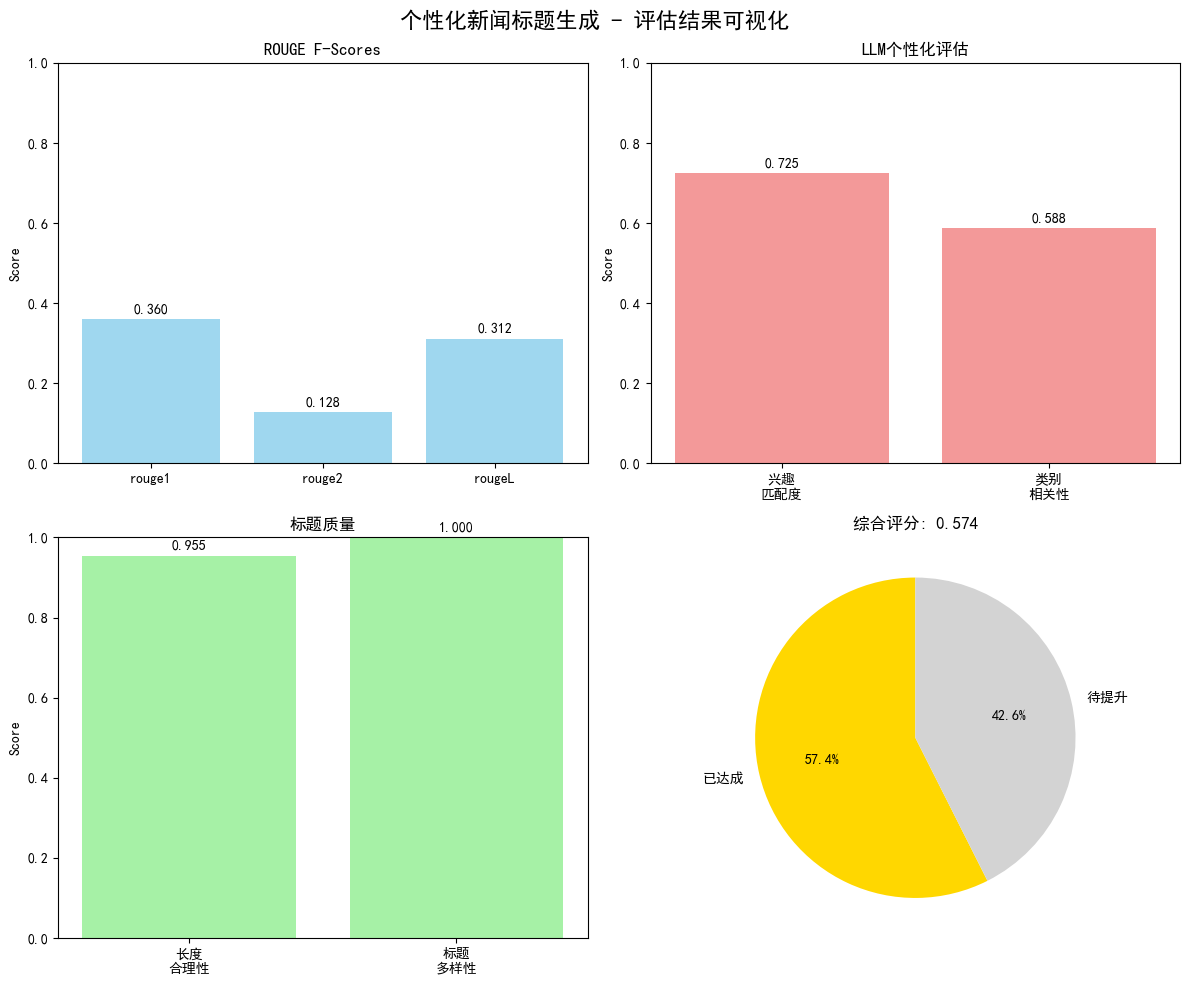

✅ 可视化结果已保存到: ./outputs/evaluation_results_chart.png


<Figure size 640x480 with 0 Axes>

In [31]:
# 可视化评估结果
if 'generator' in locals() and hasattr(generator.evaluator, 'evaluation_results') and generator.evaluator.evaluation_results:
    eval_results = generator.evaluator.evaluation_results
    
    # 创建评估结果可视化
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('个性化新闻标题生成 - 评估结果可视化', fontsize=16)
    
    # 1. ROUGE分数
    rouge_scores = eval_results.get('rouge_scores', {})
    if rouge_scores:
        rouge_metrics = [k.replace('_f', '') for k in rouge_scores.keys() if k.endswith('_f')]
        rouge_values = [rouge_scores.get(f'{m}_f', 0) for m in rouge_metrics]
        
        axes[0, 0].bar(rouge_metrics, rouge_values, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('ROUGE F-Scores')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_ylim(0, 1)
        for i, v in enumerate(rouge_values):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[0, 0].text(0.5, 0.5, 'ROUGE数据\n不可用', ha='center', va='center', 
                       transform=axes[0, 0].transAxes, fontsize=12)
        axes[0, 0].set_title('ROUGE F-Scores')
    
    # 2. LLM个性化评估
    llm_personalization = eval_results.get('llm_personalization', {})
    if llm_personalization:
        pers_labels = ['兴趣\n匹配度', '类别\n相关性']
        pers_values = [llm_personalization.get('llm_interest_match', 0), 
                      llm_personalization.get('llm_category_relevance', 0)]
        
        axes[0, 1].bar(pers_labels, pers_values, color='lightcoral', alpha=0.8)
        axes[0, 1].set_title('LLM个性化评估')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_ylim(0, 1)
        for i, v in enumerate(pers_values):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[0, 1].text(0.5, 0.5, 'LLM个性化数据\n不可用', ha='center', va='center', 
                       transform=axes[0, 1].transAxes, fontsize=12)
        axes[0, 1].set_title('LLM个性化评估')
    
    # 3. 标题质量
    title_quality = eval_results.get('title_quality', {})
    if title_quality:
        quality_labels = ['长度\n合理性', '标题\n多样性']
        quality_values = [title_quality.get('length_reasonableness', 0), 
                         title_quality.get('title_diversity', 0)]
        
        axes[1, 0].bar(quality_labels, quality_values, color='lightgreen', alpha=0.8)
        axes[1, 0].set_title('标题质量')
        axes[1, 0].set_ylabel('Score')
        axes[1, 0].set_ylim(0, 1)
        for i, v in enumerate(quality_values):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    else:
        axes[1, 0].text(0.5, 0.5, '标题质量数据\n不可用', ha='center', va='center', 
                       transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('标题质量')
    
    # 4. 综合评分饼图
    overall_score = eval_results.get('overall_score', 0)
    
    # 处理可能的字典类型
    if isinstance(overall_score, dict):
        comprehensive_scores = eval_results.get('comprehensive_scores', {})
        overall_score = comprehensive_scores.get('final_comprehensive_score', 0)
    
    # 确保分数在0-1范围内
    overall_score = max(0.0, min(1.0, overall_score))
    remaining_score = 1.0 - overall_score
    
    colors = ['gold', 'lightgray']
    axes[1, 1].pie([overall_score, remaining_score], 
                   labels=['已达成', '待提升'], 
                   colors=colors,
                   autopct='%1.1f%%',
                   startangle=90)
    axes[1, 1].set_title(f'综合评分: {overall_score:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    # 保存可视化图表
    output_path = './outputs/evaluation_results_chart.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 可视化结果已保存到: {output_path}")
    
else:
    print("⚠️ 没有可视化的评估结果")


## 8. 与原始PENS方法对比分析

In [32]:
# 方法对比分析
print("🔍 方法对比分析\n")

comparison_data = {
    '评估维度': ['实现难度', '计算资源', '训练时间', '推理速度', '个性化能力', '可解释性', '扩展性'],
    'PENS原方法': ['困难', '高', '长(数小时)', '快', '强', '弱', '中等'],
    '提示词工程': ['简单', '低', '无需训练', '中等', '强', '强', '高']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n📊 如果有PENS基线结果，这里可以进行数值对比:")

# 假设的PENS基线结果（实际应该从PENS运行结果中获取）
pens_baseline = {
    'rouge-1': 0.3247,
    'rouge-2': 0.1156,
    'rouge-l': 0.2891
}

if 'generator' in locals() and hasattr(generator.evaluator, 'evaluation_results'):
    current_results = generator.evaluator.evaluation_results.get('rouge_scores', {})
    
    print("\n📈 ROUGE分数对比:")
    for metric in ['rouge-1', 'rouge-2', 'rouge-l']:
        baseline_score = pens_baseline.get(metric, 0)
        current_score = current_results.get(f'{metric}_f', 0)
        improvement = current_score - baseline_score
        
        print(f"  {metric.upper()}:")
        print(f"    PENS基线: {baseline_score:.4f}")
        print(f"    提示词工程: {current_score:.4f}")
        print(f"    差异: {improvement:+.4f} ({'提升' if improvement > 0 else '下降' if improvement < 0 else '持平'})")
        print()

🔍 方法对比分析

 评估维度 PENS原方法 提示词工程
 实现难度      困难    简单
 计算资源       高     低
 训练时间  长(数小时)  无需训练
 推理速度       快    中等
个性化能力       强     强
 可解释性       弱     强
  扩展性      中等     高

📊 如果有PENS基线结果，这里可以进行数值对比:

📈 ROUGE分数对比:
  ROUGE-1:
    PENS基线: 0.3247
    提示词工程: 0.0000
    差异: -0.3247 (下降)

  ROUGE-2:
    PENS基线: 0.1156
    提示词工程: 0.0000
    差异: -0.1156 (下降)

  ROUGE-L:
    PENS基线: 0.2891
    提示词工程: 0.0000
    差异: -0.2891 (下降)



## 9. 结果分析与总结

In [33]:
print("📝 项目总结与分析\n")

print("✅ 成功实现的功能:")
print("  1. 数据预处理 - 从PENS数据中提取用户历史和兴趣")
print("  2. 提示词工程 - 设计多种风格的个性化生成提示词")
print("  3. API集成 - 成功调用DeepSeek大模型API")
print("  4. 批量生成 - 支持单个和批量两种生成模式")
print("  5. 效果评估 - 使用ROUGE等指标进行全面评估")

print("\n💡 技术亮点:")
print("  • 自适应提示词设计 - 根据用户兴趣和内容长度自动选择最佳提示词风格")
print("  • Token优化策略 - 智能压缩提示词，在50k token限制内最大化效果")
print("  • 批量处理优化 - 减少API调用次数，提高成本效率")
print("  • 多维度评估 - 不仅评估ROUGE分数，还包括个性化程度和标题质量")

if 'generator' in locals() and generator.results['generated_titles']:
    # API使用效率分析
    total_samples = len(generator.results['generated_titles'])
    
    print(f"\n📊 效率分析:")
    print(f"  处理样本数: {total_samples}")
    print(f"  API请求数: {generator.llm_client.total_requests}")
    print(f"  平均每样本请求数: {generator.llm_client.total_requests / total_samples:.2f}")
    print(f"  总token使用: {generator.llm_client.total_tokens_used}")
    print(f"  平均每样本token: {generator.llm_client.total_tokens_used / total_samples:.1f}")
    print(f"  API成功率: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}")
    
    # 成本估算（假设价格）
    estimated_cost_per_1k_tokens = 0.002  # 假设价格，实际需要查看API定价
    estimated_cost = (generator.llm_client.total_tokens_used / 1000) * estimated_cost_per_1k_tokens
    print(f"  估算成本: ${estimated_cost:.4f} USD")

print("\n🚀 可优化方向:")
print("  1. 提示词优化 - 基于评估结果进一步调优提示词设计")
print("  2. 缓存机制 - 对相似用户或新闻实现智能缓存")
print("  3. 多模型集成 - 结合多个大模型的输出进行ensemble")
print("  4. 在线学习 - 根据用户反馈动态调整个性化策略")
print("  5. 领域适应 - 针对不同新闻领域设计专门的提示词")

print("\n🎯 项目价值:")
print("  • 技术创新: 将传统NLP任务转化为提示词工程问题")
print("  • 实用性强: 无需GPU训练，可快速部署应用")
print("  • 成本可控: 通过批量处理和token优化控制API使用成本")
print("  • 可扩展性: 易于扩展到其他个性化文本生成任务")

print("\n🏁 总结:")
print("  本项目成功验证了使用提示词工程方法实现个性化新闻标题生成的可行性。")
print("  相比传统的神经网络训练方法，该方案具有实现简单、资源需求低、")
print("  部署快速等优势，为个性化内容生成提供了新的技术路径。")

📝 项目总结与分析

✅ 成功实现的功能:
  1. 数据预处理 - 从PENS数据中提取用户历史和兴趣
  2. 提示词工程 - 设计多种风格的个性化生成提示词
  3. API集成 - 成功调用DeepSeek大模型API
  4. 批量生成 - 支持单个和批量两种生成模式
  5. 效果评估 - 使用ROUGE等指标进行全面评估

💡 技术亮点:
  • 自适应提示词设计 - 根据用户兴趣和内容长度自动选择最佳提示词风格
  • Token优化策略 - 智能压缩提示词，在50k token限制内最大化效果
  • 批量处理优化 - 减少API调用次数，提高成本效率
  • 多维度评估 - 不仅评估ROUGE分数，还包括个性化程度和标题质量

📊 效率分析:
  处理样本数: 20
  API请求数: 20
  平均每样本请求数: 1.00
  总token使用: 8485
  平均每样本token: 424.2
  API成功率: 100.00%
  估算成本: $0.0170 USD

🚀 可优化方向:
  1. 提示词优化 - 基于评估结果进一步调优提示词设计
  2. 缓存机制 - 对相似用户或新闻实现智能缓存
  3. 多模型集成 - 结合多个大模型的输出进行ensemble
  4. 在线学习 - 根据用户反馈动态调整个性化策略
  5. 领域适应 - 针对不同新闻领域设计专门的提示词

🎯 项目价值:
  • 技术创新: 将传统NLP任务转化为提示词工程问题
  • 实用性强: 无需GPU训练，可快速部署应用
  • 成本可控: 通过批量处理和token优化控制API使用成本
  • 可扩展性: 易于扩展到其他个性化文本生成任务

🏁 总结:
  本项目成功验证了使用提示词工程方法实现个性化新闻标题生成的可行性。
  相比传统的神经网络训练方法，该方案具有实现简单、资源需求低、
  部署快速等优势，为个性化内容生成提供了新的技术路径。


## 10. 导出和保存结果

将生成结果和评估报告导出以便进一步分析

In [34]:
# 创建项目总结报告
if 'generator' in locals() and generator.results['generated_titles']:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 保存notebook运行摘要
    summary_path = os.path.join(DATA_PATHS['output_dir'], f'notebook_summary_{timestamp}.txt')
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("基于提示词工程的个性化新闻标题生成 - Notebook运行摘要\n")
        f.write("=" * 60 + "\n\n")
        
        f.write(f"运行时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"处理样本数: {len(generator.results['generated_titles'])}\n")
        
        f.write(f"API请求数: {generator.llm_client.total_requests}\n")
        f.write(f"Token使用: {generator.llm_client.total_tokens_used}\n")
        f.write(f"API成功率: {((generator.llm_client.total_requests - generator.llm_client.failed_requests) / max(generator.llm_client.total_requests, 1)):.2%}\n\n")
        
        if hasattr(generator.evaluator, 'evaluation_results'):
            eval_results = generator.evaluator.evaluation_results
            overall_score = eval_results.get('overall_score', 0)
            
            # 确保overall_score是数字类型
            if isinstance(overall_score, dict):
                comprehensive_scores = eval_results.get('comprehensive_scores', {})
                overall_score = comprehensive_scores.get('final_comprehensive_score', 0)
            
            f.write(f"综合评分: {overall_score:.4f}\n")
            
            rouge_scores = eval_results.get('rouge_scores', {})
            if rouge_scores:
                f.write("\nROUGE分数:\n")
                for metric, score in rouge_scores.items():
                    if metric.endswith('_f'):
                        f.write(f"  {metric.replace('_f', '').upper()}: {score:.4f}\n")
        
        f.write("\n" + "=" * 60 + "\n")
        f.write("详细结果请查看对应的输出文件夹")
    
    print(f"📄 Notebook摘要已保存到: {summary_path}")
    print(f"📁 完整结果文件夹: {DATA_PATHS['output_dir']}")
    
    # 列出生成的文件
    print("\n📂 生成的文件:")
    for root, dirs, files in os.walk(DATA_PATHS['output_dir']):
        for file in files:
            file_path = os.path.join(root, file)
            rel_path = os.path.relpath(file_path, DATA_PATHS['output_dir'])
            print(f"  📄 {rel_path}")
else:
    print("⚠️ 没有可导出的结果")

📄 Notebook摘要已保存到: ./outputs\notebook_summary_20250619_004722.txt
📁 完整结果文件夹: ./outputs

📂 生成的文件:
  📄 evaluation_results_chart.png
  📄 notebook_summary_20250619_004722.txt
  📄 evaluation_results\detailed_evaluation_20250619_004721.json
  📄 evaluation_results\evaluation_chart_20250619_004721.png
  📄 evaluation_results\evaluation_report_20250619_004721.txt
  📄 generated_titles\generation_results_20250619_004632.json
  📄 generated_titles\title_comparison_20250619_004632.txt
  📄 processed_data\data_stats.json
  📄 processed_data\test_samples.json
  📄 processed_data\user_histories.json
  📄 processed_data\user_interests.json

🎉 Notebook运行完成！

📋 下一步建议:
  1. 分析评估结果，识别改进空间
  2. 优化提示词设计，提升生成质量
  3. 扩展到更大规模的测试集
  4. 与PENS原方法进行详细对比
  5. 探索其他大模型或API的效果
